In [ ]:
# Start writing code here...

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression


In [ ]:
path = ""

In [ ]:
# from google.colab import drive 
# drive.mount('/content/drive',force_remount=True)
# path = "/content/drive/MyDrive/209 Project/"

Mounted at /content/drive


In [ ]:
# change the path to the temp_static file
sd_agg = pd.read_csv(path + 'data/temp_static.csv')
fips = pd.unique(sd_agg['fip']).tolist()
print(len(fips))

2682


In [ ]:
sd_agg['fip'] = sd_agg['fip'].apply(lambda x: str(int(x)).zfill(5))

In [ ]:
# We only choose stay-at-home ration(SAH) and short-trip-ratio(STR) in the naive model
# Calculate SAH and STR for past 7 days
for i in range(1,8):
    # avg_stay_at_home_ratio
    col_name1 = "SAH_lag_%s"%(i)
    sd_agg[col_name1] = sd_agg.groupby('fip')['avg_stay_at_home_ratio'].shift(i)

    # short_trip_ratio
    col_name2 = "STR_lag_%s"%(i)
    sd_agg[col_name2] = sd_agg.groupby('fip')['short_trip_ratio'].shift(i)

In [ ]:
sd_agg.columns

Index(['fip', 'County Name', 'State', 'date', 'daily_confirmed', 'new_cases',
       'trip_ratio', 'short_trip_ratio', 'med_trip_ratio', 'long_trip_ratio',
       'avg_stay_at_home_ratio', 'log_new_cases',
       'mean_neighbor_daily_confirmed', 'mean_neightbor_new_cases',
       'neighbor_log_new_cases', 'over_65_percent', 'no_diploma_percent',
       'no_insurance_percent', 'unemployed_percent', 'poverty_percent',
       'over_65_percent.1', 'beds_per_1000', 'SAH_lag_1', 'STR_lag_1',
       'SAH_lag_2', 'STR_lag_2', 'SAH_lag_3', 'STR_lag_3', 'SAH_lag_4',
       'STR_lag_4', 'SAH_lag_5', 'STR_lag_5', 'SAH_lag_6', 'STR_lag_6',
       'SAH_lag_7', 'STR_lag_7'],
      dtype='object')

In [ ]:
# Select features from social distance data 
sd_cols = ['date', 'fip', 
        'STR_lag_1','STR_lag_2', 'STR_lag_3', 'STR_lag_4', 
        'STR_lag_5', 'STR_lag_6','STR_lag_7', 'SAH_lag_1', 
        'SAH_lag_2', 'SAH_lag_3', 'SAH_lag_4',
       'SAH_lag_5', 'SAH_lag_6', 'SAH_lag_7']
sd_lagged = sd_agg[sd_cols]

In [ ]:
sd_lagged.head()

,date,fip,STR_lag_1,STR_lag_2,STR_lag_3,STR_lag_4,STR_lag_5,STR_lag_6,STR_lag_7,SAH_lag_1,SAH_lag_2,SAH_lag_3,SAH_lag_4,SAH_lag_5,SAH_lag_6,SAH_lag_7
0,2020-05-02,01001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-03,01001,0.776026,NaN,NaN,NaN,NaN,NaN,NaN,0.192281,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-05-04,01001,0.781745,0.776026,NaN,NaN,NaN,NaN,NaN,0.219870,0.192281,NaN,NaN,NaN,NaN,NaN
3,2020-05-05,01001,0.752440,0.781745,0.776026,NaN,NaN,NaN,NaN,0.183648,0.219870,0.192281,NaN,NaN,NaN,NaN
4,2020-05-06,01001,0.734856,0.752440,0.781745,0.776026,NaN,NaN,NaN,0.176598,0.183648,0.219870,0.192281,NaN,NaN,NaN


In [ ]:
# load daily confirmed cases raw data
daily_cases = pd.read_csv(path + 'data/covid_cases/covid_confirmed_usafacts_new.csv')
daily_cases['fip'] = daily_cases['countyFIPS'].apply(lambda x: str(x).zfill(5))
daily_cases = daily_cases[1:]
daily_cases.head()

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,fip
1,1001,Autauga County,AL,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1805,1818,1828,1831,1839,1852,1863,1882,1898,1905,1911,1924,1928,1949,1966,1983,1989,1999,2010,2021,2023,2030,2048,2059,2074,2082,2103,2126,2141,2159,2173,2186,2197,2212,2230,2242,2267,2283,2304,01001
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6024,6048,6073,6085,6116,6134,6141,6172,6190,6203,6220,6248,6270,6285,6333,6350,6369,6375,6405,6443,6475,6615,6637,6658,6694,6712,6743,6768,6888,6940,6966,6985,6995,7061,7097,7134,7188,7226,7263,01003
3,1005,Barbour County,AL,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,902,921,921,921,923,927,927,939,942,942,944,950,950,965,968,977,981,981,988,996,997,1012,1031,1033,1033,1042,1045,1055,1056,1060,1061,1065,1074,1079,1080,1090,1092,1095,1098,01005
4,1007,Bibb County,AL,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,675,678,686,687,691,703,708,719,726,736,738,744,744,761,771,775,785,789,791,801,811,825,828,840,843,850,856,861,866,873,878,883,890,897,907,917,924,926,932,01007
5,1009,Blount County,AL,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1642,1655,1656,1662,1665,1673,1681,1689,1704,1713,1722,1742,1750,1768,1783,1807,1827,1838,1848,1873,1893,1911,1925,1932,1942,1972,1988,2009,2039,2074,2095,2108,2162,2188,2222,2253,2286,2297,2335,01009


In [ ]:
# convert original data to format ['fip', 'County Name', 'State', 'date', 'daily_confirmed']

# get daily confirmed per row
tmp = daily_cases.copy()
cols = daily_cases.columns[4:-1]# daily cases data
tmp['daily_confirmed'] = tmp[cols].values.tolist()
# tmp['time_list'] = [list(cols)]*tmp.shape[0]

# convert list of pd.Series then stack it
tmp = (tmp
 .set_index(['fip','County Name','State'])['daily_confirmed']
 .apply(pd.Series)
 .stack()
 .reset_index()
 .rename(columns={0:'daily_confirmed'}))


tmp2 = daily_cases.copy()
cols = daily_cases.columns[4:-1]
tmp2['time_list'] = [list(cols)]*tmp2.shape[0]

tmp2 = (tmp2
 .set_index(['fip','County Name','State'])['time_list']
 .apply(pd.Series)
 .stack()
 .reset_index()
 .rename(columns={0:'old_date'}))

cases_daily = pd.merge(tmp,tmp2,on=list(tmp.columns[:4]))
del tmp,tmp2,daily_cases

# convert date format to be consistent with social distance data
def date_in_sd(case_date):
    tmp = '2020-'+case_date.split('/')[0].zfill(2)+'-'+ case_date.split('/')[1].zfill(2)
    return tmp

cases_daily['date'] = cases_daily['old_date'].apply(date_in_sd)
cases_daily = cases_daily[['fip', 'County Name', 'State', 'date', 'daily_confirmed']]

In [ ]:
# shift data to get lag1-lag7
cases_agg = cases_daily.copy()
for i in range(1,8):
    col_name = "confirmed_lag_%s"%(i)
    cases_agg[col_name] = cases_daily.groupby('fip')['daily_confirmed'].shift(i)

cases_agg[cases_agg["date"] == "2020-05-22"].head(1)

,fip,County Name,State,date,daily_confirmed,confirmed_lag_1,confirmed_lag_2,confirmed_lag_3,confirmed_lag_4,confirmed_lag_5,confirmed_lag_6,confirmed_lag_7
121,01001,Autauga County,AL,2020-05-22,149,147.0,136.0,127.0,120.0,110.0,110.0,103.0


In [ ]:
# merge cases lag data and social distance lag data
cases_sd = pd.merge(cases_agg,sd_lagged,on = ['fip','date'])
cases_sd = cases_sd.dropna(axis=0,how='any')

def trans_date(old):
    return int(old.split('-')[0]+old.split('-')[1]+old.split('-')[2])

# transform date to int for better time filtering
cases_sd['date'] = cases_sd['date'].apply(trans_date)

cases_sd.reset_index(drop=True,inplace=True)
# cases_sd.to_csv('data/merged_cases_sd.csv')

display(cases_sd.head())
display(cases_sd.shape)

,fip,County Name,State,date,daily_confirmed,confirmed_lag_1,confirmed_lag_2,confirmed_lag_3,confirmed_lag_4,confirmed_lag_5,confirmed_lag_6,confirmed_lag_7,STR_lag_1,STR_lag_2,STR_lag_3,STR_lag_4,STR_lag_5,STR_lag_6,STR_lag_7,SAH_lag_1,SAH_lag_2,SAH_lag_3,SAH_lag_4,SAH_lag_5,SAH_lag_6,SAH_lag_7
0,01001,Autauga County,AL,20200509,68,67.0,61.0,58.0,53.0,53.0,48.0,45.0,0.726209,0.719131,0.725631,0.734856,0.752440,0.781745,0.776026,0.171742,0.170968,0.189493,0.176598,0.183648,0.219870,0.192281
1,01001,Autauga County,AL,20200510,74,68.0,67.0,61.0,58.0,53.0,53.0,48.0,0.773974,0.726209,0.719131,0.725631,0.734856,0.752440,0.781745,0.191579,0.171742,0.170968,0.189493,0.176598,0.183648,0.219870
2,01001,Autauga County,AL,20200511,84,74.0,68.0,67.0,61.0,58.0,53.0,53.0,0.776957,0.773974,0.726209,0.719131,0.725631,0.734856,0.752440,0.184277,0.191579,0.171742,0.170968,0.189493,0.176598,0.183648
3,01001,Autauga County,AL,20200512,91,84.0,74.0,68.0,67.0,61.0,58.0,53.0,0.743597,0.776957,0.773974,0.726209,0.719131,0.725631,0.734856,0.144314,0.184277,0.191579,0.171742,0.170968,0.189493,0.176598
4,01001,Autauga County,AL,20200513,93,91.0,84.0,74.0,68.0,67.0,61.0,58.0,0.754343,0.743597,0.776957,0.773974,0.726209,0.719131,0.725631,0.141418,0.144314,0.184277,0.191579,0.171742,0.170968,0.189493


(472032, 26)

In [ ]:
# split training set（before October） and testing set(October), and modeling 
train_data = cases_sd[cases_sd['date']<20201001]
test_data = cases_sd[cases_sd['date']>=20201001]

x_train = train_data.iloc[:,5:]
y_train = train_data['daily_confirmed']

x_test = test_data.iloc[:,5:]
y_test = test_data['daily_confirmed']

reg = Ridge(alpha=0.01)
reg.fit(x_train, y_train)
pred = reg.predict(x_test)

In [ ]:
# get non-iter testing results: always use previous 7 days true data to predict next day
result=test_data.copy()
result['pred']=pred.tolist()

In [ ]:
fips = pd.unique(result['fip'])
all_features = ['confirmed_lag_1', 'confirmed_lag_2', 'confirmed_lag_3',
       'confirmed_lag_4', 'confirmed_lag_5', 'confirmed_lag_6',
       'confirmed_lag_7', 'STR_lag_1', 'STR_lag_2', 'STR_lag_3', 'STR_lag_4',
       'STR_lag_5', 'STR_lag_6', 'STR_lag_7', 'SAH_lag_1', 'SAH_lag_2',
       'SAH_lag_3', 'SAH_lag_4', 'SAH_lag_5', 'SAH_lag_6', 'SAH_lag_7']
ratio_features = ['STR_lag_1', 'STR_lag_2', 'STR_lag_3', 'STR_lag_4',
       'STR_lag_5', 'STR_lag_6', 'STR_lag_7', 'SAH_lag_1', 'SAH_lag_2',
       'SAH_lag_3', 'SAH_lag_4', 'SAH_lag_5', 'SAH_lag_6', 'SAH_lag_7']

In [ ]:
# get iter testing results: first use previous 7 days true data to predict the day, 
# then use previous 6 day+ yesterday's prediction to predict the day, and so on.

all_preds_test = pd.DataFrame(columns=list(result.columns)+['iter_pred'])
for fip in fips:
    one_county = result[result['fip']==fip]
    one_county['iter_pred'] = np.nan
    x_today = np.array(one_county[all_features].iloc[0]).reshape(1, -1) 
    preds = []
    pred = reg.predict(x_today)[0]
    preds.append(pred)
    for i in range(1,one_county.shape[0]):
        x_today[0][1:7]=x_today[0][0:6]# confirmed cases shift one day
        x_today[0][7:] =np.array(one_county[ratio_features].iloc[i]).reshape(1, -1) # get new lag ratio features
        x_today[0][0]=pred# use yesterday's prediction as lag-1 confirmed cases 
        pred = reg.predict(x_today)[0] # get prediction for today
        preds.append(pred)
    one_county['iter_pred']=preds
    all_preds_test = pd.concat([all_preds_test,one_county])

流式输出内容被截断，只能显示最后 5000 行内容。
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [ ]:
# calculate per county avg percentage error for iter-pred and non-iter-pred

def calc_percent(pred,true):
    if true==0 and pred!=0:
        return 1
    else:
        return abs(pred-true)/true

naive_model_per_county = pd.DataFrame(columns=['fip', 'County Name', 'State','pred_error','iter_pred_error'])
pred_error = []
iter_pred_error = []
per_fip = []
per_county = []
per_state = []
for fip in fips:
    one_county_error = all_preds_test[all_preds_test['fip']==fip]
    one_county_error['pred_abs_pecent'] = one_county_error.apply(lambda row: calc_percent(row['pred'], row['daily_confirmed']), axis=1)
    one_county_error['iter_pred_abs_pecent'] = one_county_error.apply(lambda row: calc_percent(row['iter_pred'], row['daily_confirmed']), axis=1)
    pred_error.append(one_county_error['pred_abs_pecent'].mean())
    iter_pred_error.append(one_county_error['iter_pred_abs_pecent'].mean())
    per_fip.append(fip)
    per_county.append(one_county_error['County Name'].iloc[0])# county and state keeps the same within one fip
    per_state.append(one_county_error['State'].iloc[0])

naive_model_per_county['pred_error'] = pred_error
naive_model_per_county['iter_pred_error'] = iter_pred_error
naive_model_per_county['fip'] = per_fip
naive_model_per_county['County Name'] = per_county
naive_model_per_county['State'] = per_state
naive_model_per_county.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,fip,County Name,State,pred_error,iter_pred_error
0,01001,Autauga County,AL,0.002414,0.007956
1,01003,Baldwin County,AL,0.005537,0.026249
2,01005,Barbour County,AL,0.004894,0.053942
3,01007,Bibb County,AL,0.004754,0.034971
4,01009,Blount County,AL,0.002962,0.033877


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


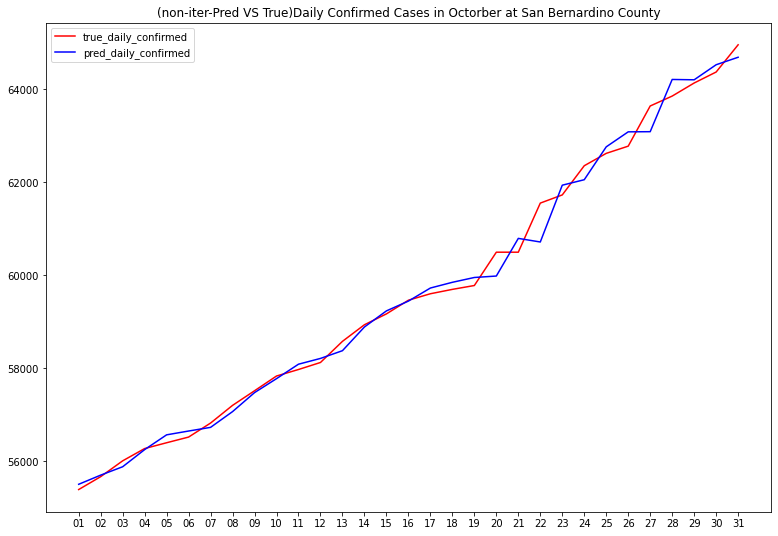

In [ ]:
# randomly select one county for October visualization
one_county = all_preds_test[all_preds_test['fip']=='06071']
one_county['date'] = one_county['date'].apply(lambda x:str(x)[6:])
plt.figure(figsize=(13, 9))
l1=plt.plot(one_county['date'],one_county['daily_confirmed'],'r',label='true_daily_confirmed')
l2=plt.plot(one_county['date'],one_county['pred'],'b',label='pred_daily_confirmed')
plt.legend()
plt.title('(non-iter-Pred VS True)Daily Confirmed Cases in Octorber at San Bernardino County')
# plt.savefig('graphs/(non-iter-Pred VS True)Daily Confirmed Cases in Octorber at San Bernardino County.png')
plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


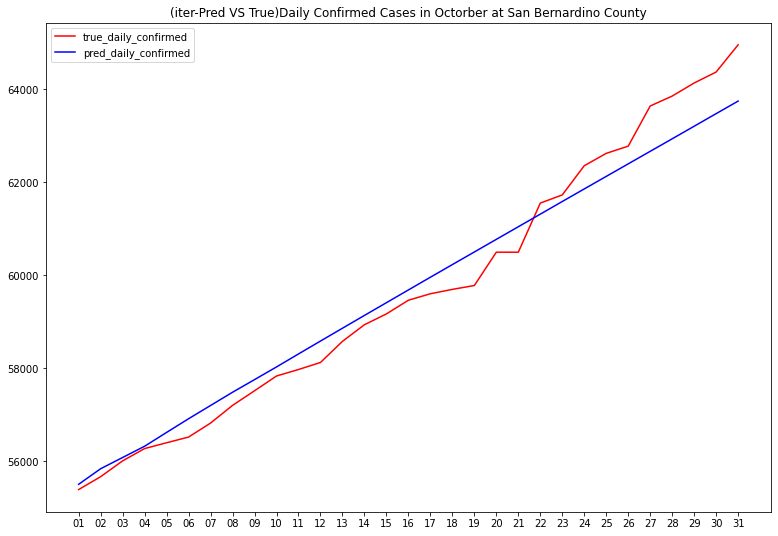

In [ ]:
one_county = all_preds_test[all_preds_test['fip']=='06071']
one_county['date'] = one_county['date'].apply(lambda x:str(x)[6:])
plt.figure(figsize=(13, 9))
l1=plt.plot(one_county['date'],one_county['daily_confirmed'],'r',label='true_daily_confirmed')
l2=plt.plot(one_county['date'],one_county['iter_pred'],'b',label='pred_daily_confirmed')
plt.legend()
plt.title('(iter-Pred VS True)Daily Confirmed Cases in Octorber at San Bernardino County')
# plt.savefig('graphs/(iter-Pred VS True)Daily Confirmed Cases in Octorber at San Bernardino County.png')
plt.show()

From the above two figures, we found that simple linear model is not good for iteration prediction because its error would become larger and larger. 

In [ ]:
naive_model_per_county.to_csv(path + 'data/naive_model_per_county.csv')
all_preds_test.to_csv(path + 'data/naive_all_preds_test.csv')